# Analyzing a double hanger resonator (S Param)
### Prerequisite
You must have a working local installation of Ansys.

In [1]:
%load_ext autoreload
%autoreload 2

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
import pyEPR as epr

## Create the design in Metal
Set up a design of a given dimension. Dimensions will be respected in the design rendering.
<br>
Note the chip design is centered at origin (0,0). 

In [2]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '2mm'
design.chips.main.size['size_y'] = '2mm'

gui = MetalGUI(design)

Perform the necessary imports.

In [3]:
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround

Add 2 transmons to the design.

In [4]:
options = dict(
    # Some options we want to modify from the deafults
    # (see below for defaults)
    pad_width = '425 um', 
    pocket_height = '650um',
    # Adding 4 connectors (see below for defaults)
    connection_pads=dict( 
        a = dict(loc_W=+1,loc_H=+1), 
        b = dict(loc_W=-1,loc_H=+1, pad_height='30um'),
        c = dict(loc_W=+1,loc_H=-1, pad_width='200um'),
        d = dict(loc_W=-1,loc_H=-1, pad_height='50um')
    )
)

## Create 2 transmons

q1 = TransmonPocket(design, 'Q1', options = dict(
    pos_x='+1.4mm', pos_y='0mm', orientation = '90', **options))
q2 = TransmonPocket(design, 'Q2', options = dict(
    pos_x='-0.6mm', pos_y='0mm', orientation = '90', **options))

gui.rebuild()
gui.autoscale()

Add 2 hangers consisting of capacitively coupled transmission lines.

In [5]:
TQ1 = CoupledLineTee(design, 'TQ1', options=dict(pos_x='1mm',
                                             pos_y='3mm',
                                             coupling_length='200um'))
TQ2 = CoupledLineTee(design, 'TQ2', options=dict(pos_x='-1mm',
                                             pos_y='3mm',
                                             coupling_length='200um'))

gui.rebuild()
gui.autoscale()

Add 2 meandered CPWs connecting the transmons to the hangers.

In [6]:
ops=dict(fillet='90um')
design.overwrite_enabled = True

options1 = Dict(
    total_length='8mm',
    hfss_wire_bonds = True,
    pin_inputs=Dict(
        start_pin=Dict(
            component='TQ1',
            pin='second_end'),
        end_pin=Dict(
            component='Q1',
            pin='a')),
    lead=Dict(
        start_straight='0.1mm'),
    **ops
)

options2 = Dict(
    total_length='9mm',
    hfss_wire_bonds = True,
    pin_inputs=Dict(
        start_pin=Dict(
            component='TQ2',
            pin='second_end'),
        end_pin=Dict(
            component='Q2',
            pin='a')),
    lead=Dict(
        start_straight='0.1mm'),
    **ops
)

meanderQ1 = RouteMeander(design, 'meanderQ1', options=options1)
meanderQ2 = RouteMeander(design, 'meanderQ2', options=options2)

gui.rebuild()
gui.autoscale()

Add 2 open to grounds at the ends of the horizontal CPW.

In [7]:
otg1 = OpenToGround(design, 'otg1', options = dict(pos_x='3mm', 
                                                   pos_y='3mm'))
otg2 = OpenToGround(design, 'otg2', options = dict(pos_x = '-3mm', 
                                                   pos_y='3mm', 
                                                   orientation='180'))

gui.rebuild()
gui.autoscale()

Add 3 straight CPWs that comprise the long horizontal CPW.

In [8]:
ops_oR = Dict(hfss_wire_bonds = True,
              pin_inputs=Dict(
                 start_pin=Dict(
                     component='TQ1',
                     pin='prime_end'),
                 end_pin=Dict(
                     component='otg1',
                     pin='open')))
ops_mid = Dict(hfss_wire_bonds = True,
               pin_inputs=Dict(
                 start_pin=Dict(
                     component='TQ1',
                     pin='prime_start'),
                 end_pin=Dict(
                     component='TQ2',
                     pin='prime_end')))
ops_oL = Dict(hfss_wire_bonds = True,
              pin_inputs=Dict(
                 start_pin=Dict(
                     component='TQ2',
                     pin='prime_start'),
                 end_pin=Dict(
                     component='otg2',
                     pin='open')))

cpw_openRight = RouteStraight(design, 'cpw_openRight', options=ops_oR)
cpw_middle = RouteStraight(design, 'cpw_middle', options=ops_mid)
cpw_openLeft = RouteStraight(design, 'cpw_openLeft', options=ops_oL)

gui.rebuild()
gui.autoscale()

## 2. Eigenmode and Impedance analysis using the `advanced` flow

If you are interested in the `recommended` flow, please check the tutorial notebook 4.3. In this section we will use the advanced flow, which directly operates on the simulator thorugh the renderer commands.

#### Setup

Select the analysis you intend to run from the `qiskit_metal.analyses.simulation` collection.<br>
Select the design to analyze and the tool to use for any external simulation.

In [9]:
from qiskit_metal.analyses.simulation.scattering_impedance import ScatteringImpedanceSim
em1 = ScatteringImpedanceSim(design, "hfss")

For the DrivenModal simulation portion, you can either:
1. Use the `em1` user-friendly methods (see tutorial 4.3)
2. Control directly the simulation tool from the tool's GUI (outside metal - see specific vendor instructions)
3. Use the renderer methods
In this section we show the advanced method (method 3).

The renderer can be reached from the analysis class. Let's give it a shorter alias.

In [10]:
hfss = em1.renderer

Now we connect to the tool using the unified command.

In [11]:
hfss.start()

INFO 06:21AM [connect_project]: Connecting to Ansys Desktop API...
INFO 06:21AM [load_ansys_project]: 	Opened Ansys App
INFO 06:21AM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 06:21AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project23
INFO 06:21AM [connect_design]: No active design found (or error getting active design).
INFO 06:21AM [connect]: 	 Connected to project "Project23". No design detected


True

#### Execute simulation and verify convergence

Create and activate an eigenmode design called "HangingResonators".

In [12]:
hfss.activate_ansys_design("HangingResonators", 'drivenmodal')

06:21AM 42s WARNING [activate_ansys_design]: The design_name=HangingResonators was not in active project.  Designs in active project are: 
[].  A new design will be added to the project.  
INFO 06:21AM [connect_design]: 	Opened active design
	Design:    HangingResonators [Solution type: DrivenModal]
WARNING 06:21AM [connect_setup]: 	No design setup detected.
WARNING 06:21AM [connect_setup]: 	Creating drivenmodal default setup.
INFO 06:21AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)


Set the buffer width at the edge of the design to be 0.5 mm in both directions.

In [13]:
hfss.options['x_buffer_width_mm'] = 0.5
hfss.options['y_buffer_width_mm'] = 0.5

#### Execute simulation and observe the Impedence
Assign lumped ports on the two cpw terminations. Then observe the impedance plots.

Here, pins cpw_openRight_end and cpw_openLeft_end are converted into lumped ports with an impedance of 50 Ohms. <br>
Neither of the junctions in Q1 or Q2 are rendered.

In [14]:
hfss.render_design(selection=[], 
                   open_pins=[], 
                   port_list=[('cpw_openRight', 'end', 50), ('cpw_openLeft', 'end', 50)], 
                   jj_to_port=[], 
                   ignored_jjs=[('Q1', 'rect_jj'), ('Q2', 'rect_jj')],
                   box_plus_buffer = True)

(optional) Captures the renderer GUI.

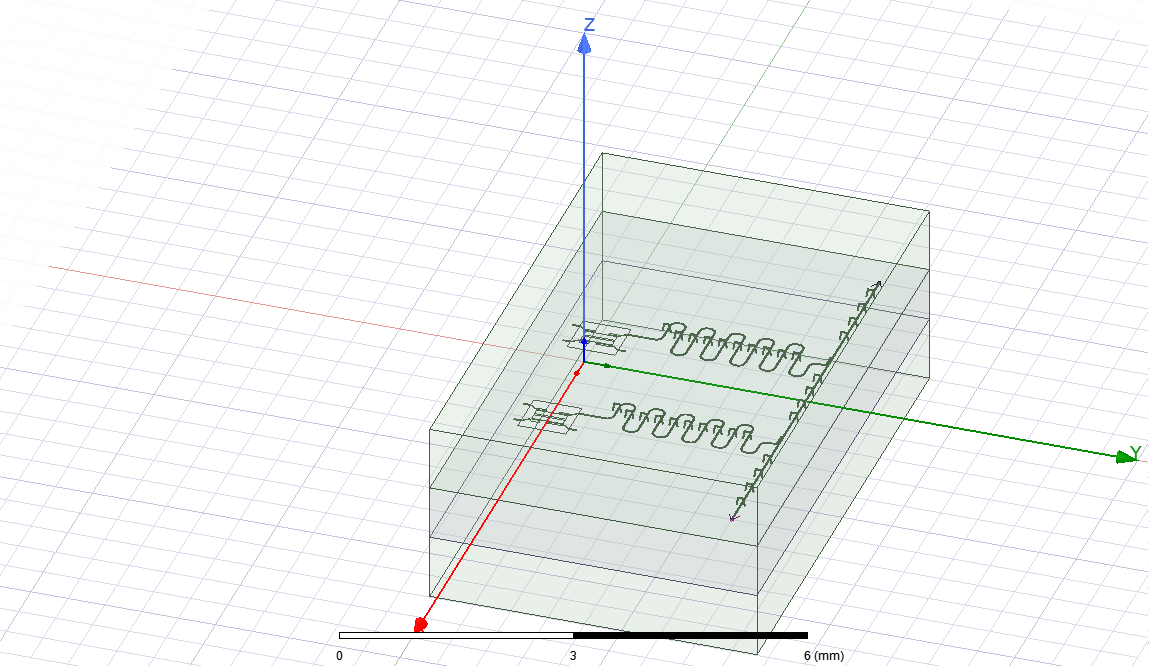

In [15]:
hfss.save_screenshot()

Create the frequency sweep to observe the impedance, admittance and scattering matrices.

In [16]:
hfss.add_sweep(setup_name="Setup", 
               name="Sweep", 
               start_ghz=4.0,
               stop_ghz=8.0,
               count=2001,
               type="Interpolating")

INFO 06:23AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)


In [17]:
hfss.analyze_sweep('Sweep', 'Setup')

INFO 06:23AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 06:23AM [analyze]: Analyzing setup Setup : Sweep


Plot S, Y, and Z parameters as a function of frequency. <br>
The left and right plots display the magnitude and phase, respectively.

In [18]:
hfss.plot_params(['S11', 'S21'])

(                      S11                 S21
 4.000 -0.143617-0.041106j -0.276574+0.949311j
 4.002 -0.143666-0.041021j -0.275970+0.949483j
 4.004 -0.143716-0.040936j -0.275366+0.949654j
 4.006 -0.143765-0.040851j -0.274762+0.949826j
 4.008 -0.143814-0.040765j -0.274157+0.949997j
 ...                   ...                 ...
 7.992 -0.037350+0.059355j  0.834663+0.546278j
 7.994 -0.037260+0.059299j  0.835022+0.545741j
 7.996 -0.037170+0.059244j  0.835381+0.545204j
 7.998 -0.037080+0.059189j  0.835739+0.544667j
 8.000 -0.036990+0.059133j  0.836097+0.544129j
 
 [2001 rows x 2 columns],
 <Figure size 3000x1800 with 2 Axes>)

In [19]:
hfss.plot_params(['Y11', 'Y21'])

(                      Y11                 Y21
 4.000 -0.000000-0.006918j -0.000000-0.024393j
 4.002  0.000000-0.006902j  0.000000-0.024388j
 4.004  0.000000-0.006885j  0.000000-0.024384j
 4.006  0.000000-0.006869j  0.000000-0.024379j
 4.008  0.000000-0.006853j  0.000000-0.024374j
 ...                   ...                 ...
 7.992  0.000000+0.034993j -0.000000-0.041781j
 7.994  0.000000+0.035040j -0.000000-0.041820j
 7.996  0.000000+0.035088j -0.000000-0.041860j
 7.998  0.000000+0.035136j -0.000000-0.041900j
 8.000  0.000000+0.035184j  0.000000-0.041939j
 
 [2001 rows x 2 columns],
 <Figure size 3000x1800 with 2 Axes>)

In [20]:
hfss.plot_params(['Z11', 'Z21'])

(                       Z11                  Z21
 4.000 -0.000000-12.573899j  0.000000+44.561044j
 4.002  0.000000-12.544109j  0.000004+44.552788j
 4.004  0.000001-12.514329j  0.000007+44.544553j
 4.006  0.000001-12.484561j  0.000011+44.536341j
 4.008  0.000002-12.454803j  0.000015+44.528149j
 ...                    ...                  ...
 7.992 -0.000049+67.825480j -0.000052+80.740443j
 7.994 -0.000037+67.924162j -0.000039+80.824275j
 7.996 -0.000025+68.023050j -0.000026+80.908315j
 7.998 -0.000012+68.122145j -0.000013+80.992565j
 8.000  0.000000+68.221447j  0.000000+81.077025j
 
 [2001 rows x 2 columns],
 <Figure size 3000x1800 with 2 Axes>)

Finally, disconnect from Ansys.

In [21]:
em1.close()

(optional) close the GUI.

In [22]:
# gui.main_window.close()